In [1]:
import numpy as np
import porespy as ps
import pyglet
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.ndimage as spim
import skimage
from skimage import io
import pickle as pk
import pandas as pd

In [2]:
im = io.imread('4201_RIM_20-03343-10_20ppi_909x909x909_red.tif')

In [3]:
im.shape

(400, 400, 400)

In [4]:
bn = int(np.log2(im.flatten().shape[0])) + 1

### Threshold method test

In [5]:
## https://scikit-image.org/docs/dev/auto_examples/applications/plot_thresholding.html#sphx-glr-auto-examples-applications-plot-thresholding-py

from skimage.filters import threshold_isodata
from skimage.filters import threshold_li
from skimage.filters import threshold_local
from skimage.filters import threshold_mean
from skimage.filters import threshold_minimum
from skimage.filters import threshold_multiotsu
from skimage.filters import threshold_niblack
from skimage.filters import threshold_otsu
from skimage.filters import threshold_sauvola
from skimage.filters import threshold_triangle
from skimage.filters import threshold_yen

In [6]:
def binarize(im, threshold):
    boolean = im > threshold
    binarized = np.multiply(boolean, 1)
    return binarized

def por(mat):
    por = 1 - mat.mean()
    return por

In [7]:
isodata = threshold_isodata(im)

In [8]:
li = threshold_li(im)

In [9]:
mean = threshold_mean(im)

In [10]:
multiotsu = threshold_multiotsu(im)

In [11]:
otsu = threshold_otsu(im)

In [12]:
triangle = threshold_triangle(im)

In [13]:
yen = threshold_yen(im)

In [14]:
# local = threshold_local(im)
# minimum = threshold_minimum(im)
# niblack = threshold_niblack(im)
# sauvola = threshold_sauvola(im)

In [15]:
por_threshold = {
                "Isodata": round(por(binarize(im,isodata)), 2),
                "Li": round(por(binarize(im,li)), 2),
                "Mean": round(por(binarize(im,mean)), 2),
                "Multiotsu": round(por(binarize(im,multiotsu[1])), 2),
                "Otsu": round(por(binarize(im,otsu)), 2),
                "Triangle": round(por(binarize(im,triangle)), 2),
                "Yen": round(por(binarize(im,yen)), 2),
#                 "IFPEN": 0.91,
#                 "Manifacturer": 0.93
                }


In [16]:
por_thr = pd.DataFrame(por_threshold.values(), index=por_threshold.keys(), 
                       columns=['por']).sort_values('por')

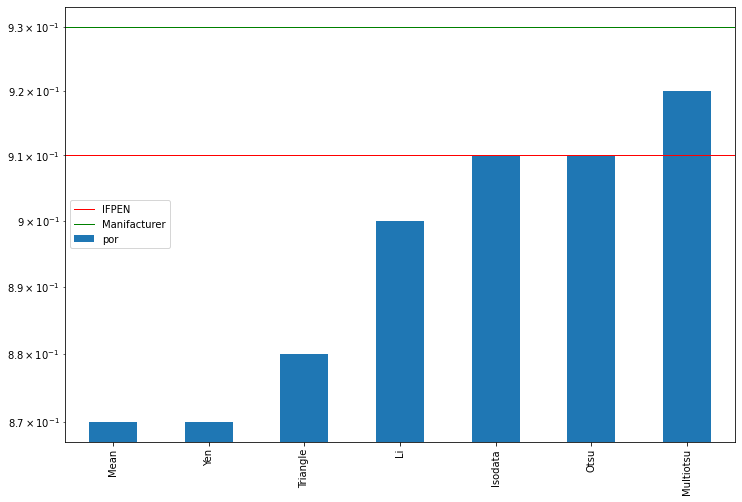

In [17]:
ax = por_thr.plot(kind='bar',legend=False, logy=True, figsize=(12,8))
ax.axhline(y=0.91,label='IFPEN',lw=1, c='r')
ax.axhline(y=0.93,label='Manifacturer',lw=1, c='g')
ax.legend();

In [18]:
threshold_value = 31116
threshold_value2 = 35000
threshold_value3 = 43000
threshold_value4 = 40000

In [19]:
mat1 = binarize(im,threshold_value)
mat2 = binarize(im,threshold_value2)
mat3 = binarize(im,threshold_value3)
mat4 = binarize(im,threshold_value4)

In [20]:
print('porosity with threshold 1 =',round(por(mat1), 3))
print('porosity with threshold 2 =',round(por(mat2), 3))
print('porosity with threshold 3 =',round(por(mat3), 3))
print('porosity with threshold 4 =',round(por(mat4), 3))

porosity with threshold 1 = 0.873
porosity with threshold 2 = 0.897
porosity with threshold 3 = 0.919
porosity with threshold 4 = 0.911


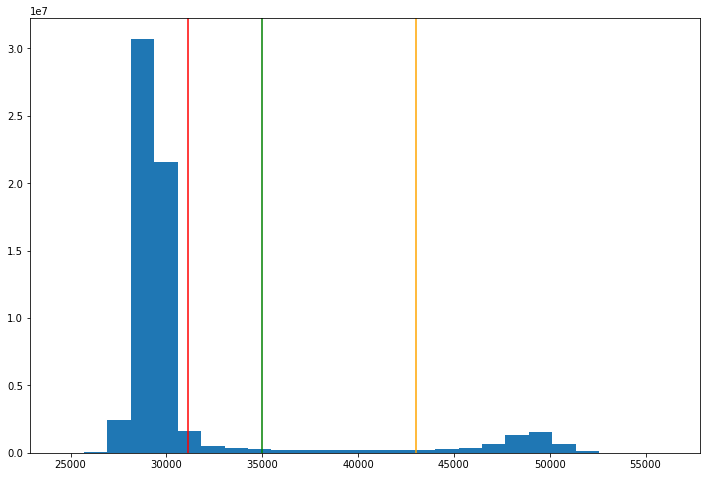

In [21]:
fig, ax = plt.subplots(figsize=(12,8))
histplot = ax.hist(im.flatten(), bins=bn)
threshold_line1 = ax.axvline(x=threshold_value, c='red')
threshold_line2 = ax.axvline(x=threshold_value2, c='green')
threshold_line2 = ax.axvline(x=threshold_value3, c='orange')

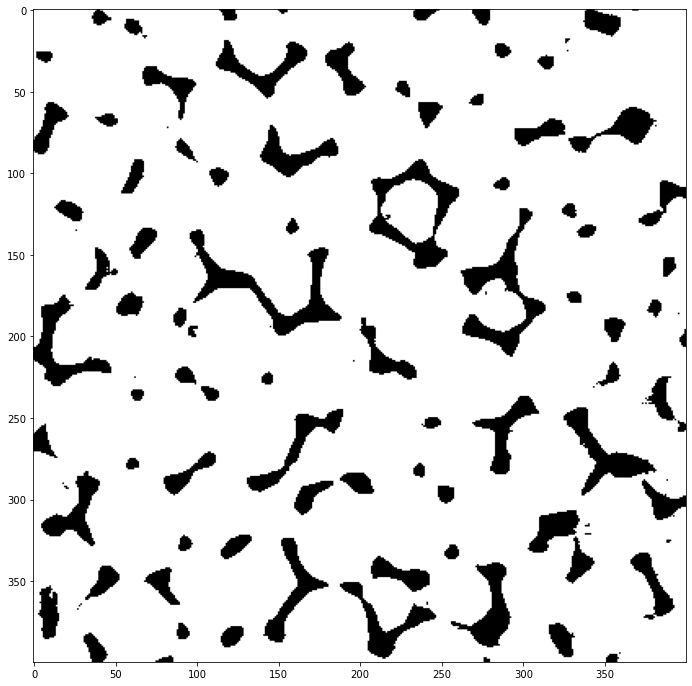

In [22]:
fig1,ax1 = plt.subplots(figsize=(12,12))
slice_y1 = ax1.imshow(mat1[:,0,:], cmap=plt.cm.binary)

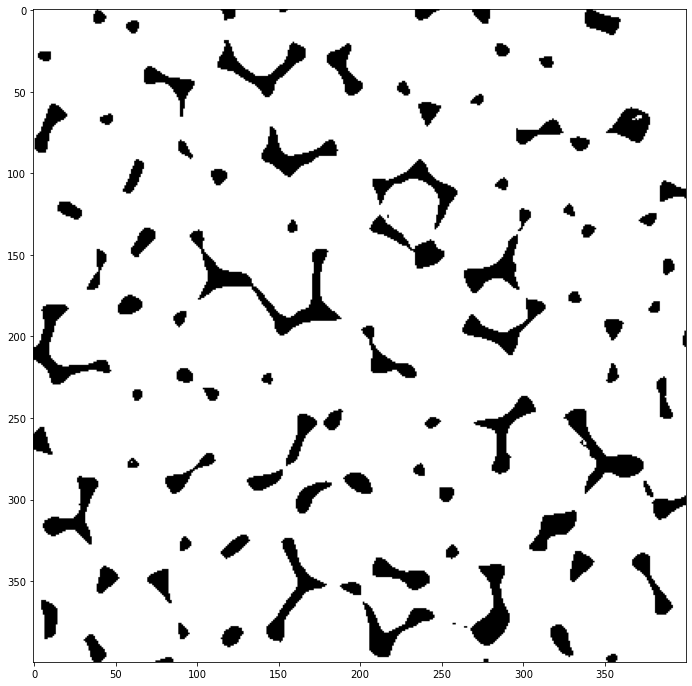

In [23]:
fig2,ax2 = plt.subplots(figsize=(12,12))
slice_y2 = ax2.imshow(mat2[:,0,:], cmap=plt.cm.binary)

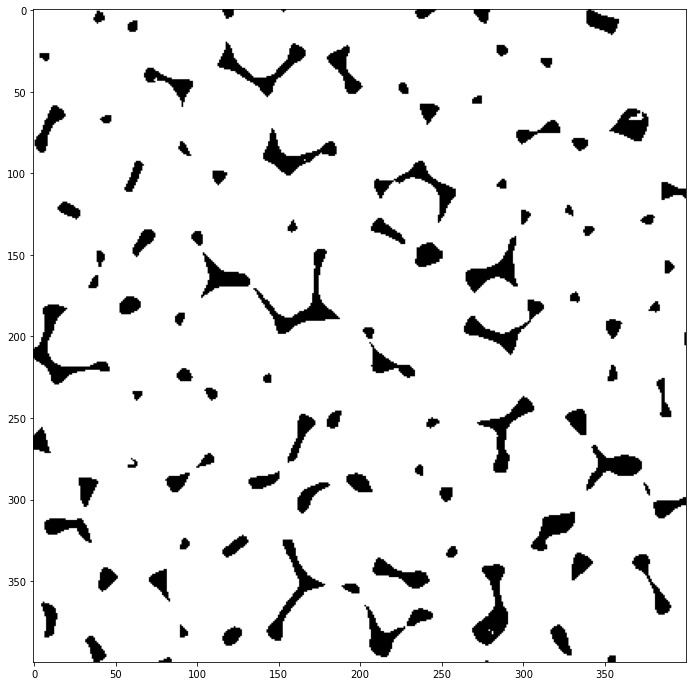

In [24]:
fig3,ax3 = plt.subplots(figsize=(12,12))
slice_y3 = ax3.imshow(mat3[:,0,:], cmap=plt.cm.binary)

In [25]:
mat3_= np.logical_not(mat3)

In [16]:
thk = ps.filters.local_thickness(mat3_, sizes= 300, mode='dt')

100%|██████████| 300/300 [22:14<00:00,  4.45s/it]


In [18]:
with open('thk.pkl','wb') as f:
    pk.dump(thk,f)

In [26]:
with open('thk.pkl','rb') as f:
    thk = pk.load(f)

In [27]:
voxel_size = 50 * 1e-6

In [28]:
thk_r = thk * voxel_size

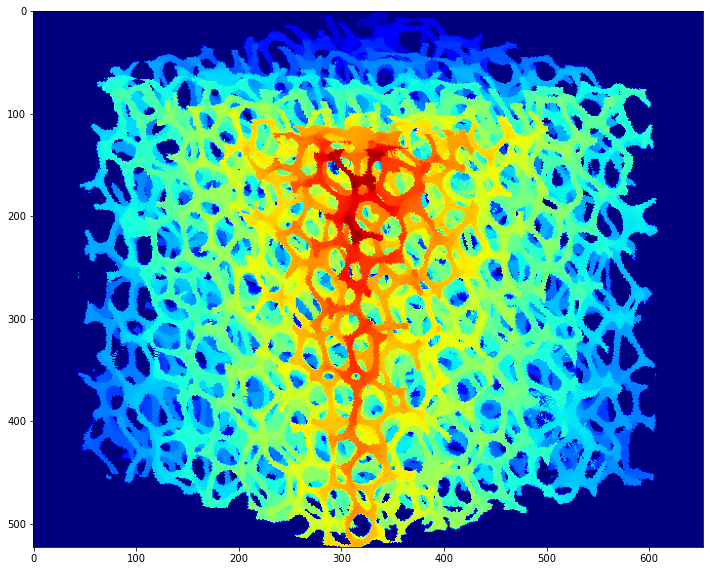

In [29]:
fig4,ax4 = plt.subplots(figsize=[12, 12])
ax4.imshow(ps.visualization.show_3D(thk.astype(np.bool)), cmap=plt.cm.jet)

### Cell size distribution

In [30]:
psd = ps.metrics.pore_size_distribution(im=thk_r,bins=20,log=False)

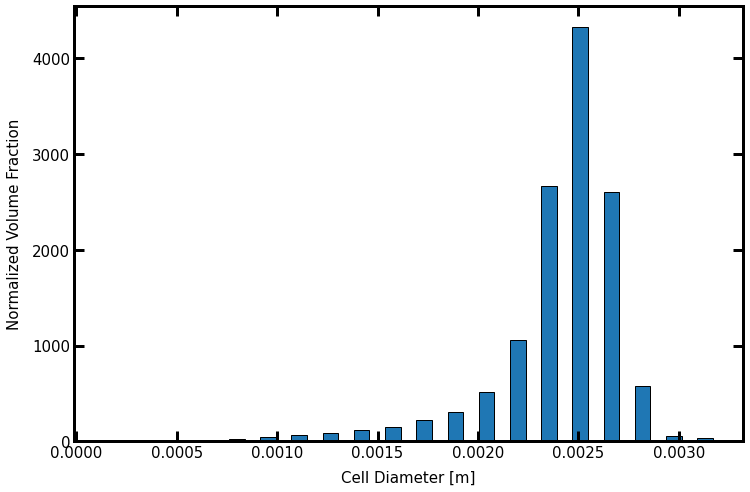

In [31]:
ps.visualization.set_mpl_style()
fig5, ax5 = plt.subplots(figsize=[12, 8])
ax5.set_xlabel('Cell Diameter [m]')
ax5.set_ylabel('Normalized Volume Fraction')
ax5.bar(x=psd.R*2, height=psd.pdf, width=psd.bin_widths, edgecolor='k')
plt.show()

In [33]:
(psd.R*2).mean()

0.0016539015566190076

In [32]:
import statistics

statistics.median(psd.R*2)

0.001653901556619008

In [183]:
np.quantile((psd.R*2),0.75)

0.0023920047960130364

### REV analysis

In [34]:
rev_size = ps.metrics.representative_elementary_volume(im=mat3_, npoints=10000)

100%|██████████| 9990/9990 [01:37<00:00, 101.98it/s]


In [35]:
voxel_VOL = voxel_size ** 3

In [36]:
total_vol = voxel_VOL*im.flatten().shape[0]

In [37]:
porosity = ps.metrics.porosity(im=mat3_)

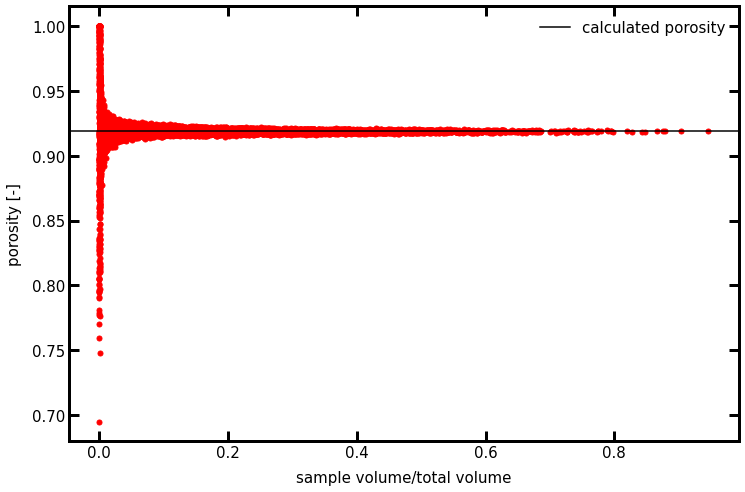

In [38]:
fig6, ax6 = plt.subplots(figsize=(12, 8))
ax6.plot(rev_size.volume*voxel_VOL/total_vol, rev_size.porosity, 'r.')
ax6.set_xlabel(r"sample volume/total volume")
ax6.set_ylabel("porosity [-]");
# ax6.axvline(x=total_vol, lw=1.5, label='total sample volume')
ax6.axhline(y=porosity,c='k',lw=1.5,label='calculated porosity')
plt.legend()

In [39]:
df_rev = pd.DataFrame([rev_size.volume*voxel_VOL/total_vol,rev_size.porosity]).T
df_rev.columns =['v','por']
df_rev = df_rev.sort_values(by=['v'])


In [40]:
# https://pbpython.com/pandas-qcut-cut.html

bin_labels = ['d1','d2','d3','d4','d5','d6','d7','d8','d9','d10']
df_rev['decile_bin'] = pd.qcut(df_rev.v,q=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],labels=bin_labels)

In [41]:
dec_cv = {}
for dec in bin_labels:
    dec_cv[dec] = 100 * df_rev.loc[df_rev['decile_bin'] == dec,'por'].std()/df_rev.loc[df_rev['decile_bin'] == dec,'por'].mean()

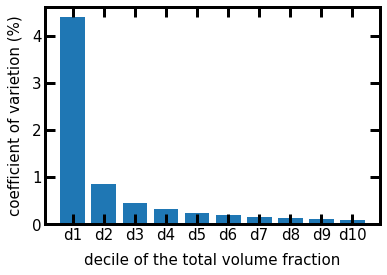

In [42]:
plt.bar(x=dec_cv.keys(), height= dec_cv.values())
plt.xlabel('decile of the total volume fraction')
plt.ylabel('coefficient of varietion (%)')
plt.savefig('rev_cv.png',facecolor=fig.get_facecolor(), edgecolor='none', bbox_inches='tight')

### struts analysis test

In [191]:
thk_st = ps.filters.local_thickness(mat3, sizes= 300, mode='dt')

100%|██████████| 300/300 [25:44<00:00,  5.15s/it]


In [43]:
with open('thk_st.pkl','rb') as f:
    thk_st = pk.load(f)

In [193]:
with open('thk_st.pkl','wb') as f:
    pk.dump(thk_st,f)

In [44]:
thk_st_r = thk_st * voxel_size

In [45]:
psd_st = ps.metrics.pore_size_distribution(im=thk_st_r,bins=20,log=False)

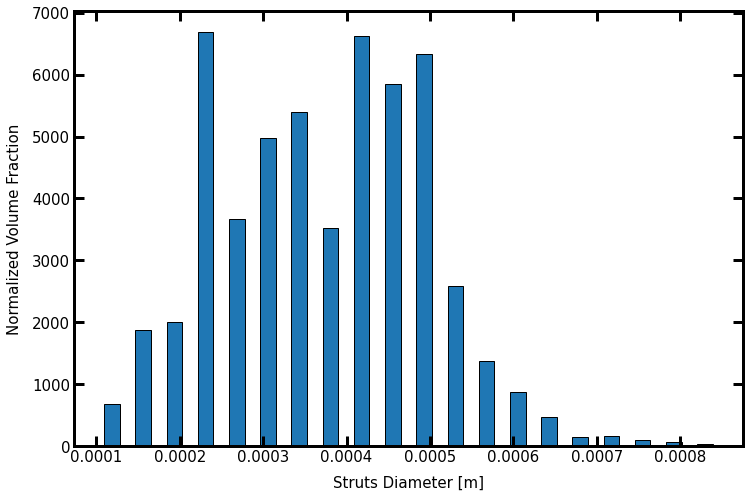

In [46]:
ps.visualization.set_mpl_style()
fig7, ax7 = plt.subplots(figsize=[12, 8])
ax7.set_xlabel('Struts Diameter [m]')
ax7.set_ylabel('Normalized Volume Fraction')
ax7.bar(x=psd_st.R*2, height=psd_st.pdf, width=psd_st.bin_widths, edgecolor='k')
plt.show()

### Window size distribution

NB: this procedure is computationally expensive in terms of RAM, consider using workstation

In [47]:
snow_output = ps.networks.snow(mat3_, voxel_size=voxel_size)

------------------------------------------------------------
Beginning SNOW Algorithm
Converting supplied image (im) to boolean
Peforming Distance Transform
Applying Gaussian blur with sigma = 0.4
Initial number of peaks:  1221
Peaks after trimming saddle points:  1103
Peaks after trimming nearby peaks:  1044
------------------------------------------------------------
Extracting pore and throat information from image
100%|██████████| 1700/1700 [00:48<00:00, 34.73it/s] 


In [48]:
snow_output

{'pore.all': array([ True,  True,  True, ...,  True,  True,  True]),
 'throat.all': array([ True,  True,  True, ...,  True,  True,  True]),
 'pore.coords': array([[0.01922117, 0.01552363, 0.00937239],
        [0.00684762, 0.00795238, 0.0198    ],
        [0.00026194, 0.001778  , 0.00545096],
        ...,
        [0.00676935, 0.0202    , 0.00178467],
        [0.0066499 , 0.0202    , 0.01166475],
        [0.00716983, 0.0202    , 0.01871689]]),
 'pore.centroid': array([[0.01922117, 0.01552363, 0.00937239],
        [0.00684762, 0.00795238, 0.0198    ],
        [0.00026194, 0.001778  , 0.00545096],
        ...,
        [0.00676935, 0.0202    , 0.00178467],
        [0.0066499 , 0.0202    , 0.01166475],
        [0.00716983, 0.0202    , 0.01871689]]),
 'throat.centroid': array([[2.010e-02, 1.450e-02, 8.600e-03],
        [1.885e-02, 1.600e-02, 1.040e-02],
        [1.870e-02, 1.485e-02, 8.650e-03],
        ...,
        [2.005e-02, 1.545e-02, 1.000e-04],
        [2.015e-02, 1.550e-02, 4.500e-04],

In [49]:
(snow_output['throat.inscribed_diameter'] == snow_output['throat.diameter']).all()

True

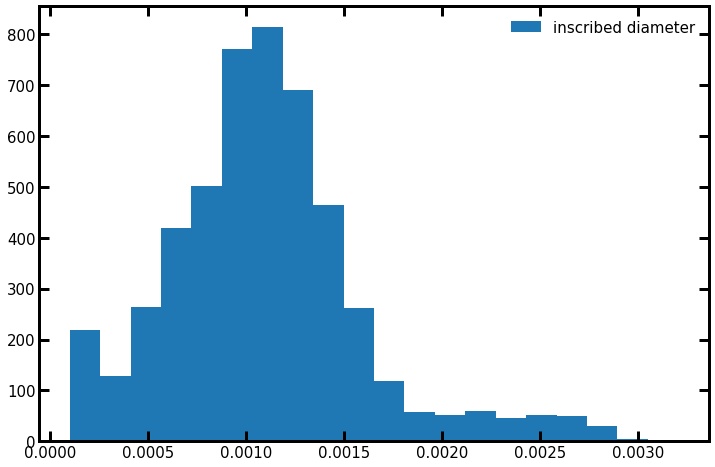

In [50]:
fig8, ax8 = plt.subplots(figsize=(12,8))
ax8.hist(snow_output['throat.inscribed_diameter'], bins=20, label='inscribed diameter')
# ax8.hist(snow_output['throat.diameter'], bins=20, label='diameter')
ax8.legend();

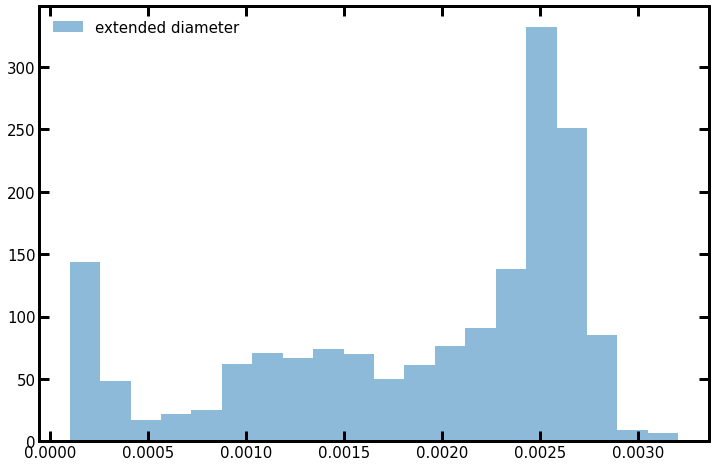

In [56]:
fig9, ax9 = plt.subplots(figsize=(12,8))
# ax9.hist(snow_output['pore.equivalent_diameter'], bins=20, label='equivalent diameter',alpha=0.5)
ax9.hist(snow_output['pore.extended_diameter'], bins=20, label='extended diameter',alpha=0.5)
# ax9.hist(snow_output['pore.inscribed_diameter'], bins=20, label='inscribed diameter',alpha=0.5)
# ax9.hist(snow_output['pore.diameter'], bins=20, label='diameter',alpha=0.5)

# ax8.hist(snow_output['throat.diameter'], bins=20, label='diameter')
ax9.legend();

In [ ]:
snow_output = ps.networks.snow(mat3_, voxel_size=voxel_size)